## Script summary
This script builds a model to predict N2 fixation (NFR) based on data collected from the Mid-/South Atlantic Bight in Aug, 2016, as follows:

1) The full training/test/validation dataset is imported and parred down appropriately (measurements made under manipulated environmental conditions eg incubated with excessive C are removed; superfluous explanatory variables eg station number, pressure, etc. are removed; nans are removed). Finally, in order to reduce over-weighting the importance of extreme values in training, the target data were log-transformed as in Sammartino et al (2018, Remote Sensing). Where n2 fixation was not detected, the log of the median detection limit was used.

2) 20% of the full dataset is randomly selected and witheld for model validation later (leaving 80% for training and testing).

3) Explanatory variables are scaled based on the training/testing data.

4) Hyperparameter sensitivity analysis is performed; the model is tuned.

5) Model performance is assessed using the validation dataset.

6) Predictive X data (satellite data) are read in and scaled.

7) Predictive X data are used to predict NFR; predicted NFR are saved for later use.

*NOTE:  Satellite-derived salinity data was not used because it was at very low resolution and did not contribute substantially to the model. PC was excluded because its distribution was more or less the same as that of chl-a, but was under-estimated by the satellite relative to in situ [PC].*

In [10]:
# This script was written using Python 3.7

import pandas as pd # written using v. 0.24.2
import numpy as np # written using v. 1.16.2
import math # written using v. 1.1.0
import matplotlib.pyplot as plt # written using v. 3.1.1
import scipy.stats as ss # written using v. 1.3.2
import cmocean # written using v. 2.0

## 1) The full training/test/validation dataset is imported and parred down appropriately

- measurements made under manipulated environmental conditions eg incubated with excessive C are removed
- superfluous explanatory variables eg station number, pressure, etc. are removed
- nans are removed

In [11]:
# import file with NFR and corresponding hydrographic information
# see Sharp16_15N2tracer_allrates_hydrograph_ReadMe.csv for full file description

infile = '..\Calculations\Sharp16_15N2tracer_allrates_hydrograph.csv' # This file contains all replicate rate measurements
df = pd.read_csv(infile)

# NFR_flag = flag for rate measurements (both FC and NFR)
#      - 0 = NFR value can be trusted
#      - 1 = analytical error occurred (e.g., 15N2 was not sufficiently enriched, PN on t=f filter was too low or high 
#            (outside linear range), autosampler/reduction column issues, etc.
#      - 2 = N2 fixation was below analytical detection limit

# If NFR_flag = 1, NFR and FC = -9999
# If NFR_flag = 2, NFR and FC = 0

# IrregInc_flag = Irregular incubation flag
#     - 0 = incubation is normal
#     - 1 = incubation conditions were manipulated (e.g., incubation was artificially dark, C was added,, or inc was 12 
#           instead of 24 hours)

print(df.shape)
df.columns

(379, 34)


Index(['UniqID', 'LocID', 'Sta', 'Depth_m', 'IrregInc_flag', 'IncLength_h',
       'IncVol_L', 'GlucoseAdd_ul', 'PCconc_uM', 'PCconc_err', 'PNconc_uM',
       'PNconc_err', 'FC_d', 'FC_LOD', 'NFR_nmolNLd', 'NFR_LOD', 'NFR_flag',
       'SeaFloor_Depth_m', 'Lat', 'Lon', 'Press_db', 'Sigmat_kgm3', 'Temp_C',
       'Sal', 'DO_umolkg', 'Fluor_mgm3', 'PO4_uM', 'PO4_err', 'NO2_uM',
       'NO2_err', 'NO3_uM', 'NO3_err', 'NH4_nM', 'NH4_err'],
      dtype='object')

In [12]:
# exclude rows where the incubation conditions were manipulated (i.e., did not represent the environment) and where
# the rate could not be calculated due to an analytical error
df = df[(df.IrregInc_flag == 0) & (df.NFR_flag !=1)]
print(df.shape)

(252, 34)


In [13]:
# select explanatory data for the model
# here, we use all available parameters deemed likely to be important

X = df.drop(['UniqID', 'LocID', 'IncVol_L', 'Sta', 'IrregInc_flag', 'IncLength_h', 'GlucoseAdd_ul', 'PNconc_uM', 'PNconc_err', 'FC_d',
             'FC_LOD', 'NFR_LOD', 'NFR_flag', 'PO4_err', 'NO2_uM', 'NO2_err', 'NO3_err', 'NH4_nM', 'NH4_err', 'PCconc_err',
             'Press_db','Sigmat_kgm3', 'Depth_m','DO_umolkg','PO4_uM','NO3_uM','Sal','Lat','Lon','PCconc_uM'], axis = 1).dropna()
y = X.NFR_nmolNLd
X = X.drop(['NFR_nmolNLd'],axis = 1)

print(np.shape(X))
print(np.shape(y))

X.head()

(252, 3)
(252,)


,SeaFloor_Depth_m,Temp_C,Fluor_mgm3
0,-1260,26.766684,0.588138
1,-1260,26.766684,0.588138
2,-1260,26.766684,0.588138
3,-1260,15.049992,2.362376
4,-1260,15.049992,2.362376


In [14]:
# target data are log-transformed
logy = []
for i in y:
    if i == 0:
        logyi = np.log10(np.median(df.NFR_LOD)) # if Nfix was not detectable, use median LOD instead of value
    else:
        logyi = np.log10(i)
    logy.append('%f' % logyi)

y = logy

In [15]:
# target data are converted back to pd df
y = pd.DataFrame(y, columns = ['nfr'])
type(y)

pandas.core.frame.DataFrame

## 2) 20% of the full dataset is randomly selected and witheld for model validation later 
(leaving 80% for training and testing)

In [16]:
from sklearn.model_selection import train_test_split # v. 0.22.1

# split dataset in training/test and validation data (80:20)
X_tt, X_val,y_tt,y_val = train_test_split(X,y,test_size = 0.2) # this split function is random

# shape of train/test and val objects
print(X_tt.shape)
print(X_val.shape)

# # reformat y_val to match y_pred later
y_val = np.array(y_val, dtype = float).reshape(len(y_val),)

print(y_val.shape)

(201, 3)
(51, 3)
(51,)


## 3) Explanatory variables are scaled based on the training/testing data

In [17]:
from sklearn.preprocessing import StandardScaler # v. 0.22.1

# scale all X data based on training dataset
scaler = StandardScaler()
scaler.fit(X_tt)

X_tt = scaler.transform(X_tt)
X_val = scaler.transform(X_val)

## 4) Hyperparameter sensitivity analysis is performed; the model is tuned

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# create model object
model = RandomForestRegressor()

# define type of cross validation to be used
cv = KFold(n_splits = 9, shuffle = True)

# set-up hyperparameter grid
treecount = np.arange(1,51,2) # number of decisions trees in the ensemble
maxdepth = np.arange(1,21,2) # longest path between root node and final node

param_grid = {'n_estimators':treecount, 'max_depth':maxdepth}

# define scoring parameters to evaluate the predictions on the test set
scoring = 'r2'

# create GridSearchCV object
grid_cv = GridSearchCV(model, param_grid, scoring = scoring, cv = cv, refit = True) # when refit = True, will refit the best
# estimator with the entire dataset

# fit model to the train/test data
grid_cv.fit(X_tt,np.ravel(y_tt, order = 'C'))

mean_test_score = grid_cv.cv_results_['mean_test_score']
std_test_score = grid_cv.cv_results_['std_test_score']
best_std_test_score = grid_cv.cv_results_['std_test_score'][mean_test_score ==  grid_cv.best_score_]

print("Tuned Parameter(s): {}".format(grid_cv.best_params_))
print("Best score is: %f +/- %f" % (grid_cv.best_score_,best_std_test_score)) # mean cross-validated score of the best estimator

Tuned Parameter(s): {'max_depth': 11, 'n_estimators': 43}
Best score is: 0.829381 +/- 0.143957


## 5) Model performance is assessed using validation dataset

VALIDATION DATASET (black line), r2:  0.901319, rmse:  0.287259, p value:  0.000000


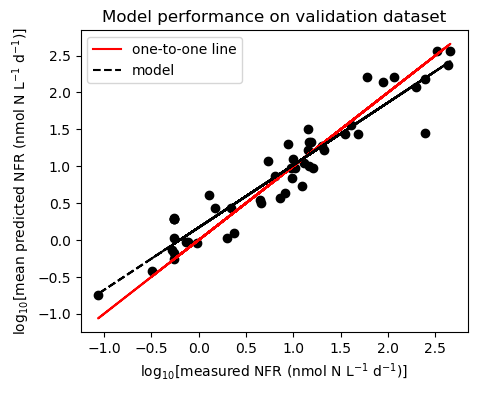

In [19]:
# predict y for validation data subset
y_pred = grid_cv.predict(X_val)

# plot predicted validation y against true validation y
fig, (ax) =  plt.subplots(1, 1, figsize = (5, 4), dpi = 100)

plt.plot(y_val,y_pred,'ko')
plt.plot(y_val,y_val, color = 'r', label = "one-to-one line")

plt.xlabel('log$_{10}$[measured NFR (nmol N L$^{-1}$ d$^{-1}$)]')
plt.ylabel('log$_{10}$[mean predicted NFR (nmol N L$^{-1}$ d$^{-1}$)]')

# perform and plot linear regression of true y against predicted y
slope, intercept, r_value, p_value, std_err = ss.linregress(y_val,y_pred)
line = slope*y_val + intercept
plt.plot(y_val,line, "k--", label = "model")

# calculate r2 and rmse using sklearn calculation method (differs slightly from ss method)
r2_comp = metrics.r2_score(y_val,y_pred)
rmse_comp = np.sqrt(metrics.mean_squared_error(y_val,y_pred))

ax.legend()
plt.title("Model performance on validation dataset")

print("VALIDATION DATASET (black line), r2:  %f, rmse:  %f, p value:  %f" % (r2_comp,rmse_comp,p_value))

##  6) Predictive X data are read in and scaled

In [20]:
# read in compiled, binned satellite data

infile = '..\Calculations\compiledseasfcdata_8daymean_2016Aug12to19_onetwentiethdegreegrid.csv'
satdf = pd.read_csv(infile)
satdf.columns

Index(['Lat', 'Lon', 'EstDepth_m', 'SeafloorDepth_m', 'Temp_c', 'Chl_mgm3',
       'PCconc_uM'],
      dtype='object')

In [21]:
# remove rows with nans in relevant columns
satdf = satdf.drop([], axis = 1).dropna()

# reorganize df to match model training data
X_sat = pd.DataFrame(data = {'sfz': satdf.SeafloorDepth_m, 'temp': satdf.Temp_c, 'chl': satdf.Chl_mgm3})

In [22]:
# scale satellite X data
X_sat = scaler.transform(X_sat)

## 7) y is predicted; data are saved for later use

In [23]:
# predict y for predictive X data
y_sat = grid_cv.predict(X_sat)

In [24]:
# save predictor variables and predicted nfr to a csv file
OutputData = pd.DataFrame(data = {'Lat': satdf.Lat, 'Lon': satdf.Lon, 'SeafloorDepth_m': satdf.SeafloorDepth_m, 'Temp_C': satdf.Temp_c, 'Chl_mgm3': satdf.Chl_mgm3, 'NFR_log10nmolNLd': y_sat})
OutputData.to_csv('../Calculations/RF_SatPred.csv')

## SUPPLEMENTAL:  Quick visualization of predicted data

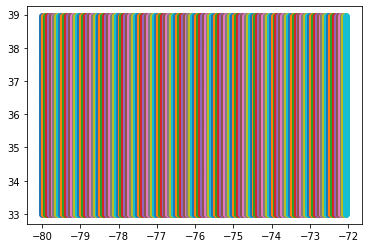

In [25]:
# need to bin the data into a grid to contour it

# make a grid
x = np.arange(-80, -72, .05)
y = np.arange(33, 39, .05)

xx, yy = np.meshgrid(x, y)

h = plt.plot(xx, yy, 'o')
plt.show()

In [26]:
# bin the data into the grid
binned = ss.binned_statistic_2d(satdf.Lon, satdf.Lat, y_sat, statistic='mean', bins=[x, y])

In [27]:
# log transform true data to plot (surface only)
logy = []
for i in (df.NFR_nmolNLd[df.Depth_m < 5]):
    if i == 0:
        logyi = np.log10(np.median(df.NFR_LOD)) # if Nfix was not detectable, use median LOD instead of value
    else:
        logyi = np.log10(i)
    logy.append('%f' % logyi)

logsfc = logy

# target data are converted back to pd df
logsfc = pd.DataFrame(logsfc, columns = ['nfr'], dtype = float)

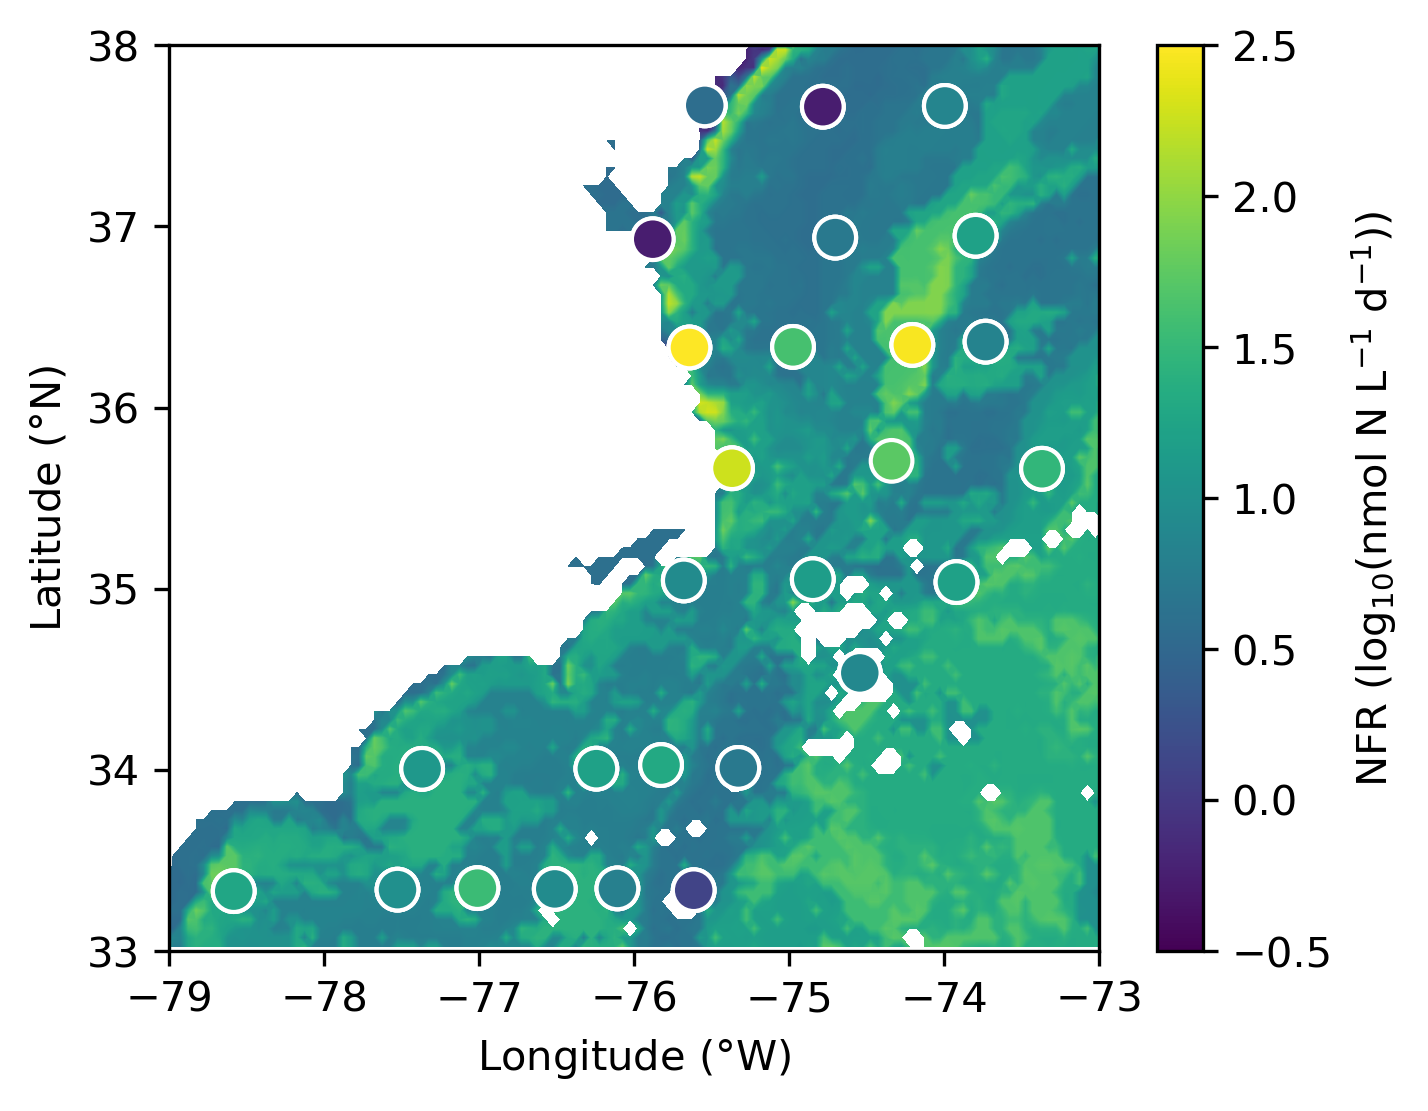

In [28]:
# plot the data
fig, (ax) =  plt.subplots(1, 1, figsize = (5, 4), dpi = 300)

# to do a contour plot, you need to reference the center of the bins, not the edges
# get the bin centers
xc = (x[:-1] + x[1:]) / 2
yc = (y[:-1] + y[1:]) / 2

plt.contourf(xc, yc, binned.statistic.T, vmin = -0.5, vmax = 2.5, levels = 1000)

# # plt.scatter(satdf.Lon,satdf.Lat, c = y_sat, vmin = -0.5, vmax = 2.75)

plt.scatter(df.Lon[df.Depth_m < 5],df.Lat[df.Depth_m < 5], c = logsfc.nfr, vmin = -0.5, vmax = 2.5, edgecolor = 'w', s = 100)
cb = plt.colorbar()
cb.set_label('NFR (log$_{10}$(nmol N L$^{-1}$ d$^{-1}$))')
plt.xlabel('Longitude ($\degree$W)')
plt.ylabel('Latitude ($\degree$N)')
plt.xlim(-79,-73)
plt.ylim(33,38)

fig.savefig('..\Figures\PredNFR_sfc_PcSfzTFl.png')